In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


/mnt/DATA/Conda_Envs/procGen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# pipeline.model.model.config

T5Config {
  "_name_or_path": "amazon/chronos-t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "chronos_config": {
    "context_length": 512,
    "eos_token_id": 1,
    "model_type": "seq2seq",
    "n_special_tokens": 2,
    "n_tokens": 4096,
    "num_samples": 20,
    "pad_token_id": 0,
    "prediction_length": 64,
    "temperature": 1.0,
    "tokenizer_class": "MeanScaleUniformBins",
    "tokenizer_kwargs": {
      "high_limit": 15.0,
      "low_limit": -15.0
    },
    "top_k": 50,
    "top_p": 1.0,
    "use_eos_token": true
  },
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 0.05,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "pa

In [3]:
# import torch
# import torch.nn as nn
# from transformers import T5ForConditionalGeneration
# import copy

# class CustomT5Block(nn.Module):
#     def __init__(self, original_block):
#         super().__init__()
#         self.original_block = original_block

#         # Define the new feedforward layer
#         self.additional_ff = nn.Sequential(
#             nn.Linear(512, 512),  # Input 512, output 512
#             nn.ReLU()
#         )
        
#     def forward(self, x, **kwargs):
#         # Pass through the original block
#         x, *additional_outputs = self.original_block(x, **kwargs)
        
#         # Check if x is a tensor and not a tuple
#         if isinstance(x, tuple):
#             x = x[0]  # Get the first tensor if it's a tuple

#         # Pass through the additional feedforward layer
#         x = self.additional_ff(x)

#         return x

# class ModifiedT5(nn.Module):
#     def __init__(self, original_model):
#         super(ModifiedT5, self).__init__()
#         self.shared = original_model.shared
#         self.encoder = original_model.encoder
#         self.decoder = original_model.decoder
#         self.lm_head = original_model.lm_head
        
#         # Create new T5Block instances with the additional FF
#         self.encoder.block = nn.ModuleList(
#             CustomT5Block(block) for block in original_model.encoder.block
#         )
        
#         self.decoder.block = nn.ModuleList(
#             CustomT5Block(block) for block in original_model.decoder.block
#         )

#         # Define additional layers
#         self.additional_dense = nn.Linear(512, 512)
#         self.layer_norm = nn.LayerNorm(512)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids, attention_mask=None, decoder_input_ids=None):
#         # Pass input through the encoder
#         encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Prepare decoder input IDs if not provided
#         if decoder_input_ids is None:
#             decoder_input_ids = input_ids  # Or use a different approach as per your task
        
#         # Pass the encoder outputs to the decoder
#         decoder_outputs = self.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_outputs[0])
        
#         # Pass decoder outputs through the language model head
#         lm_logits = self.lm_head(decoder_outputs[0])
        
#         # Pass through additional dense layer, layer norm, and dropout
#         lm_logits = self.additional_dense(lm_logits)
#         lm_logits = self.layer_norm(lm_logits)
#         lm_logits = self.dropout(lm_logits)
        
#         return lm_logits

# # Usage
# original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")
# copied_model = copy.deepcopy(original_model)
# modified_model = ModifiedT5(copied_model)

# # # Test with dummy input
# # input_ids = torch.randint(0, 4096, (1, 10))  # Batch size 1, sequence length 10
# # output = modified_model(input_ids)


In [4]:
import copy
from transformers import T5ForConditionalGeneration
from transformers import set_seed
import torch.nn as nn

set_seed(42)

class CustomFFLayer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the new feedforward layer
        self.additional_ff = nn.Sequential(
            nn.Linear(512, 512*2),  # Input 512, output 512
            nn.Linear(512*2, 512),
            nn.ReLU()
        )

            # Set weights and biases to zero
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.additional_ff:
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 0)  # Set weights to zero
                nn.init.constant_(layer.bias, 0)    # Set biases to zero
        
    def forward(self, x, **kwargs):        
        # Pass through the additional feedforward layer
        x = self.additional_ff(x)
        
        return x


class CustomT5(T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        
        # Access the first encoder block
        first_encoder_block = self.encoder.block[0]
        customLayer = CustomFFLayer()
        # Duplicate the T5LayerFF layer (which is the second layer in the block)
        # extra_ff_layer = copy.deepcopy(first_encoder_block.layer[1])  # The FF layer is the second layer in the block

        first_encoder_block.layer.insert(2,customLayer)  # Add it again
    
        # Do the same for the first decoder block
        # first_decoder_block = self.decoder.block[0]
        # extra_ff_layer_decoder = copy.deepcopy(first_decoder_block.layer[2])  # The FF layer is the third layer in the decoder block
        # first_decoder_block.layer.append(extra_ff_layer_decoder)

# Load the pre-trained model
original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")

copy_model = copy.deepcopy(original_model)

# Initialize custom model with the same configuration
custom_model = CustomT5(copy_model.config)

# Load the weights from the pre-trained model into the custom model
custom_model.load_state_dict(copy_model.state_dict(), strict=False)  # strict=False allows for architectural changes

# Now custom_model should share weights with the original model, except for the new FF layers


_IncompatibleKeys(missing_keys=['encoder.block.0.layer.2.additional_ff.0.weight', 'encoder.block.0.layer.2.additional_ff.0.bias', 'encoder.block.0.layer.2.additional_ff.1.weight', 'encoder.block.0.layer.2.additional_ff.1.bias'], unexpected_keys=[])

In [5]:
custom_model.encoder.block[0].layer[2].additional_ff[1].weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [6]:
import src.chronos.chronos
import importlib
importlib.reload(src.chronos.chronos)

import torch


context1 = torch.linspace(0, 100, 512).unsqueeze(0)
context2 = (context1.clone()[0,:]*2).unsqueeze(0)
context = torch.cat((context1, context2), dim=0)

print('context shape',context.shape)

token_ids, attention_mask, scale = (
    pipeline.tokenizer.context_input_transform(context)
)

print('token_ids shape',token_ids.shape)
print('attention_mask shape',attention_mask.shape)

context = pipeline._prepare_and_validate_context(context=context)
print('context shape after prepare and validate',context.shape)

context shape torch.Size([2, 512])
token_ids shape torch.Size([2, 513])
attention_mask shape torch.Size([2, 513])
context shape after prepare and validate torch.Size([2, 512])


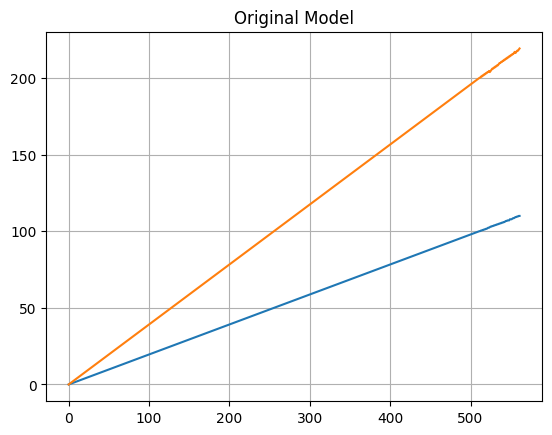

In [7]:
predictions_from_original_model = []
remaining = 50

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = original_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                # num_samples= 1,
                num_return_sequences=1,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    

    samples = samples[..., 1:]
    samples = samples.reshape(token_ids.size(0), 1, -1)
    
    prediction = pipeline.tokenizer.output_transform(
        samples.to(scale.device), scale
    )

    predictions_from_original_model.append(prediction)
    remaining -= prediction.shape[-1]

    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )


data_original_to_plot = torch.concat((context,predictions_from_original_model[0][:,0,:]),dim=1)


import matplotlib.pyplot as plt
import numpy as np
data_original_to_plot = np.array(data_original_to_plot)
plt.plot(data_original_to_plot[0,:])
plt.plot(data_original_to_plot[1,:])
plt.title("Original Model")
plt.grid()

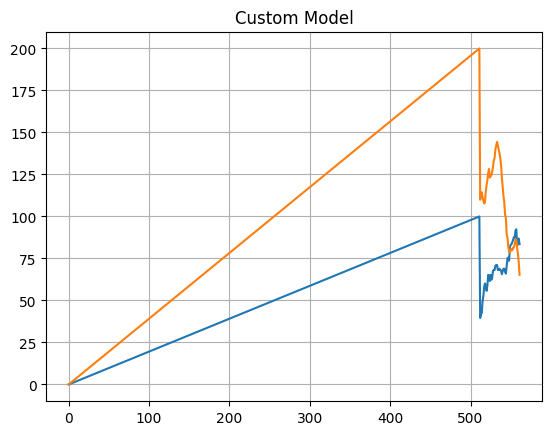

In [8]:
predictions_from_custom_model = []
remaining = 50

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = custom_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                num_return_sequences=1,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    
    samples = samples[..., 1:]
    samples = samples.reshape(token_ids.size(0), 1, -1)

    prediction = pipeline.tokenizer.output_transform(
        samples.to(scale.device), scale
    )

    predictions_from_custom_model.append(prediction)
    remaining -= prediction.shape[-1]

    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )



data_custom_to_plot = torch.concat((context,predictions_from_custom_model[0][:,0,:]),dim=1)


import matplotlib.pyplot as plt
import numpy as np
data_custom_to_plot = np.array(data_custom_to_plot)
plt.plot(data_custom_to_plot[0,:])
plt.plot(data_custom_to_plot[1,:])
plt.title("Custom Model")
plt.grid()

In [9]:
# forecast = pipeline.predict(context=context, prediction_length=50, num_samples=1)

In [10]:
# forecast.size()

In [11]:
# print('Difference between forecast from the api and manual:')
# forecast - predictions_from_original_model[0]

In [12]:
# ##### the github issue.

# import torch
# from chronos import ChronosPipeline
# from transformers import T5ForConditionalGeneration
# from transformers import set_seed

# set_seed(42)

# pipeline = ChronosPipeline.from_pretrained(
#     "amazon/chronos-t5-small",
#     device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
#     torch_dtype=torch.bfloat16,
# )

# original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")


# # Pass  two lines to the model.
# context1 = torch.linspace(0, 100, 512).unsqueeze(0)
# context2 = (context1.clone()[0,:]*2).unsqueeze(0)
# context = torch.cat((context1, context2), dim=0)


# ############################################
# # profile the manual retrieval
# import cProfile
# import pstats
# from io import StringIO

# def profile_code(context=context):
#     predictions_from_original_model = []
#     remaining = 50

#     while remaining > 0:
#         token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
#             context
#         )
#         samples = original_model.generate(
#                     input_ids=token_ids,
#                     attention_mask=attention_mask, 
#                     min_new_tokens=50,
#                     max_new_tokens=50,
#                     do_sample=True,
#                     # num_samples= 1,
#                     num_return_sequences=1,
#                     eos_token_id=pipeline.model.config.eos_token_id,
#                     pad_token_id=pipeline.model.config.pad_token_id)
        

#         samples = samples[..., 1:]
#         samples = samples.reshape(token_ids.size(0), 1, -1)
        
#         prediction = pipeline.tokenizer.output_transform(
#             samples.to(scale.device), scale
#         )

#         predictions_from_original_model.append(prediction)
#         remaining -= prediction.shape[-1]

#         if remaining <= 0:
#             break

#         context = torch.cat(
#             [context, prediction.median(dim=1).values], dim=-1
#         )

# # Profile the function
# pr = cProfile.Profile()
# pr.enable()
# profile_code()
# pr.disable()

# # Print the profiling results
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())


# ##############################################
# # profile the pipeline retrieval:
# import cProfile
# import pstats
# from io import StringIO

# def profile_code():
#     forecast = pipeline.predict(context=context, prediction_length=50, num_samples=1)

# # Profile the function
# pr = cProfile.Profile()
# pr.enable()
# profile_code()
# pr.disable()

# # Print the profiling results
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())